Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# @title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Action-Angle Networks



In [ ]:
%ls

'/workspace'

In [3]:
%mkdir -p ../notebook_outputs

mkdir: cannot create directory ‘../notebook_outputs’: Read-only file system


In [4]:
# @title Base Imports
from typing import *
import functools
import sys
import tempfile
import os

import seaborn as sns
from absl import logging
import collections
import chex
#from clu import checkpoint
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.core import frozen_dict
from flax.training import train_state
import optax
# import distrax
#import tensorflow as tf
import ml_collections
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import pysr
import yaml

PLT_STYLE_CONTEXT = ['science', 'ieee', 'grid']

sys.path.append("..")
matplotlib.rc("animation", html="jshtml")
logging.get_absl_handler().python_handler.stream = sys.stdout
logging.set_verbosity(logging.INFO)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [5]:
%load_ext autoreload

In [6]:
# %pip install -e /work/gj26/b20109/ActionAngleNetworks

In [7]:
# @title Source Imports
%autoreload 2
from action_angle_networks.simulation import harmonic_motion_simulation
from action_angle_networks import models, train, analysis
from action_angle_networks.configs.harmonic_motion import (action_angle_flow, action_angle_mlp, euler_update_flow, euler_update_mlp)

In [8]:
%load_ext tensorboard

## Training Models

You can train a model from scratch below!

In [9]:
# @title Training Configuration
config = action_angle_flow.get_config()
workdir = tempfile.mkdtemp()

In [10]:
%tensorboard --logdir={workdir} --port=0

In [ ]:
scaler, state, aux = train.train_and_evaluate(config, workdir)

INFO:absl:[Hyperparameters] {'activation': 'sigmoid', 'batch_size': 100, 'dimensions_per_trajectory': 1, 'encoder_decoder_type': 'flow', 'eval_cadence': 50, 'flow_type': 'shear', 'latent_size': 100, 'learning_rate': 0.001, 'model': 'action-angle-network', 'num_angular_velocity_net_layers': 2, 'num_flow_layers': 20, 'num_samples': 1000, 'num_train_steps': 50000, 'num_trajectories': 2, 'polar_action_angles': True, 'regularizations': {'actions': 1.0, 'angular_velocities': 0.0, 'encoded_decoded_differences': 0.0}, 'rng_seed': 0, 'scaler': 'standard', 'simulation': 'harmonic', 'simulation_parameter_ranges': {'A': (1, 10), 'k_pair': (0,), 'k_wall': (0.005, 0.01), 'm': (1, 5), 'phi': (0, 1)}, 'single_step_predictions': True, 'split_on': 'times', 'test_split_proportion': 0.5, 'test_time_jumps': (1, 2, 5, 10, 20, 50), 'time_delta': 1.0, 'train_split_proportion': 0.1, 'train_time_jump_range': (1, 10), 'train_time_jump_schedule': 'linear'}
INFO:absl:Generating data.
INFO:absl:Constructing model.


## Loading a Pre-Trained Model

In [ ]:
# @title Location of Pretrained Model
def get_input_dir_for_config(config: str) -> str:
    k_pair = "0.5"
    return f"/Users/ameyad/Documents/google-research/workdirs/supercloud/sweeps/harmonic_motion/harmonic_motion/performance_vs_samples/harmonic_motion/{config}.py/num_samples=1000/train_split_proportion=0.1/num_train_steps=50000/simulation_parameter_ranges.k_pair={k_pair}"
    #return f"/Users/ameyad/Documents/google-research/workdirs/supercloud/sweeps/harmonic_motion/harmonic_motion/performance_vs_samples/harmonic_motion/{config}.py/num_samples=1000/train_split_proportion=0.1/num_train_steps=50000/simulation_parameter_ranges.k_pair={k_pair}"

config = "action_angle_flow"
workdir = get_input_dir_for_config(config)

In [8]:
config, scaler, state, aux = analysis.load_from_workdir(workdir)

INFO:absl:Saved config found. Loading...
INFO:absl:Using loaded config directly...
INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:absl:Restoring checkpoint: /Users/ameyad/Documents/google-research/workdirs/supercloud/sweeps/harmonic_motion/harmonic_motion/performance_vs_samples/harmonic_motion/action_angle_flow.py/num_samples=1000/train_split_proportion=0.1/num_train_steps=50000/simulation_parameter_ranges.k_pair=0.5/checkpoints/ckpt-1
INFO:absl:Restored save_counter=1 restored_checkpoint=/Users/ameyad/Documents/google-research/workdir

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [ ]:
os.makedirs(f"../notebook_outputs/paper/{config_name}-no_linear/k_pair={k_pair}/", exist_ok=True)

In [9]:
train_positions = aux["train"]["positions"]
train_momentums = aux["train"]["momentums"]
train_simulation_parameters = aux["train"]["simulation_parameters"]
all_train_metrics = aux["train"]["metrics"]

test_positions = aux["test"]["positions"]
test_momentums = aux["test"]["momentums"]
test_simulation_parameters = aux["test"]["simulation_parameters"]
all_test_metrics = aux["test"]["metrics"]

(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
(
    test_positions_rescaled,
    test_momentums_rescaled,
) = train.inverse_transform_with_scaler(test_positions, test_momentums, scaler)


### Plotting Change in Hamiltonians

In [ ]:
total_changes = {
    jump: np.asarray(
        list(all_test_metrics[step][jump]["mean_change_in_hamiltonians"] for step in all_test_metrics)
    )
    for jump in config.test_time_jumps
}
steps = list(all_test_metrics.keys())

true_position, true_momentum = train.inverse_transform_with_scaler(
    test_positions[:1], test_momentums[:1], scaler
)
actual_hamiltonian = harmonic_motion_simulation.compute_hamiltonian(
    true_position, true_momentum, test_simulation_parameters
)
actual_hamiltonian = np.asarray(actual_hamiltonian).squeeze()

with plt.style.context(PLT_STYLE_CONTEXT):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(total_changes)))
    for jump_color, jump in zip(colors, config.test_time_jumps):
        total_changes_for_jump = total_changes[jump]
        ax.plot(steps, total_changes_for_jump, label=jump, color=jump_color)
    ax.axhline(y=actual_hamiltonian, c="gray", linestyle="--")
    ax.set_title("Mean Change in Hamiltonian")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Change")
    ax.set_yscale("log")
    ax.set_ylim(0.005, 300)
    ax.legend(title="Jump Size", loc="upper right", title_fontsize=6, fontsize=6)
    plt.show()
    
    fig.savefig(f"../notebook_outputs/paper/{config_name}-no_linear/k_pair={k_pair}/change_in_hamiltonian.pdf", dpi=1000)

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    fig.savefig("../notebook_outputs/test_change_in_hamiltonian.pdf", dpi=1000)


### Plotting Loss



In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    total_losses = {
        jump: np.asarray(list(all_test_metrics[step][jump]["prediction_loss"] for step in all_test_metrics))
        for jump in config.test_time_jumps
    }
    steps = list(all_test_metrics.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(total_losses)))

    fig, ax = plt.subplots()
    for jump_color, jump in zip(colors, config.test_time_jumps):
        total_losses_for_jump = total_losses[jump]
        ax.plot(steps, total_losses_for_jump, label=jump, color=jump_color)

    ax.set_title("Test Loss")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Loss")
    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.legend(title="Jump Size")
    plt.show()

In [ ]:
all_test_metrics

In [ ]:
fig.savefig("../notebook_outputs/test_losses.pdf", dpi=1000)

### Plotting Action and Angle Space

In [ ]:
# Sample position-momentum space.
max_position = 1.2 * np.abs(train_positions).max()
max_momentum = 1.2 * np.abs(train_momentums).max()
plot_positions = jnp.linspace(-max_position, max_position, num=100)
plot_momentums = jnp.linspace(-max_momentum, max_momentum, num=100)
grid = jnp.meshgrid(plot_positions, plot_momentums)
plot_positions = grid[0][:, :, jnp.newaxis]
plot_momentums = grid[1][:, :, jnp.newaxis]

# Pad the remaining coordinates with zeros.
def pad_coords(
    positions: chex.Array, momentums: chex.Array, index: int
) -> Tuple[chex.Array, chex.Array]:
    positions = jnp.pad(
        positions, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    momentums = jnp.pad(
        momentums, ((0, 0), (0, 0), (index, config.num_trajectories - index - 1))
    )
    return positions, momentums


trajectory_index = 0
plot_positions, plot_momentums = pad_coords(
    plot_positions, plot_momentums, trajectory_index
)

# Compute actions and angles.
_, _, auxiliary_predictions = jax.vmap(state.apply_fn, in_axes=(None, 0, 0, None))(
    state.params, plot_positions, plot_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

# Rescale back to original data range.
plot_positions, plot_momentums = jax.vmap(train.inverse_transform_with_scaler, in_axes=(0, 0, None))(
    plot_positions, plot_momentums, scaler
)
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
plot_positions, plot_momentums, plot_actions, plot_angles = jax.tree_map(
    lambda arr: arr[:, :, trajectory_index],
    (plot_positions, plot_momentums, plot_actions, plot_angles),
)

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_actions, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Actions Contour")
plt.show()

In [ ]:
fig.savefig("../notebook_outputs/actions_contour.pdf", dpi=1000)

In [ ]:
fig, ax = plt.subplots()
contours = ax.contour(plot_positions, plot_momentums, plot_angles, 50, cmap="viridis")
fig.colorbar(contours)
ax.plot(
    train_positions_rescaled[:, trajectory_index],
    train_momentums_rescaled[:, trajectory_index],
    c="gray",
    linestyle="--",
)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Angles Contour")
plt.show()

In [ ]:
fig.savefig("../notebook_outputs/angles_contour.pdf", dpi=1000)

### Plotting True Trajectories

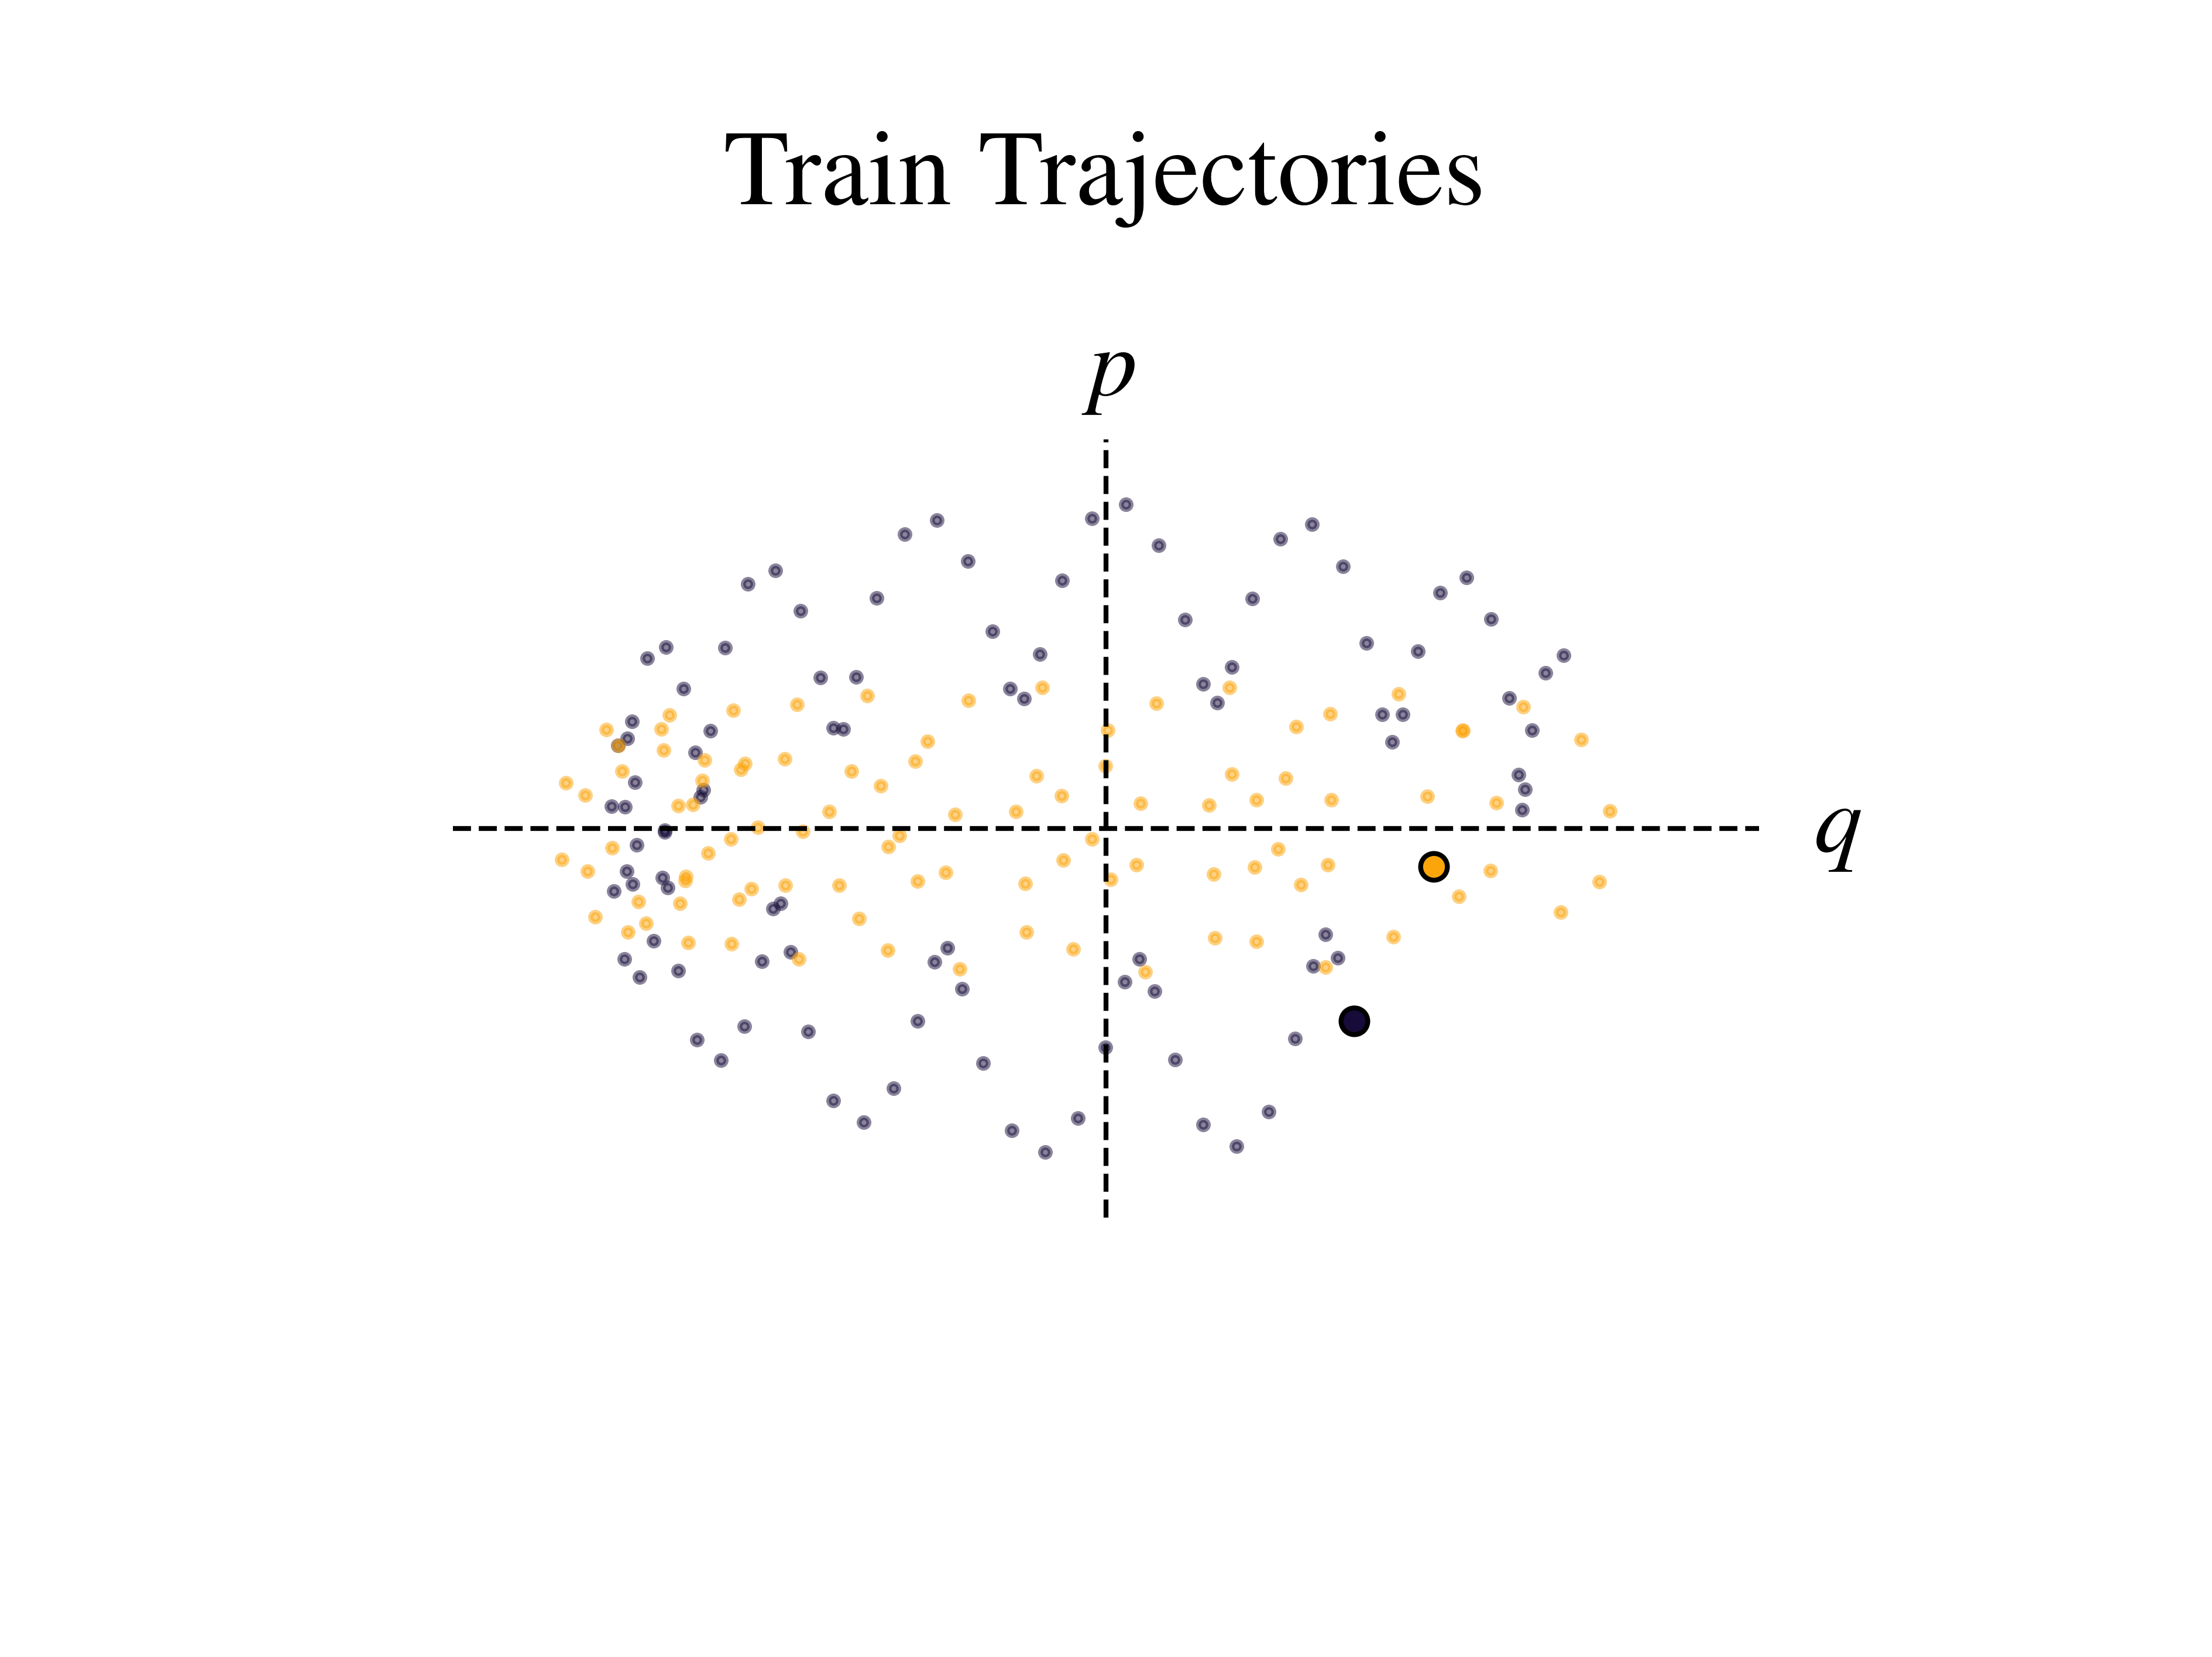

In [10]:
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        train_positions_rescaled,
        train_momentums_rescaled,
        title="Train Trajectories",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [11]:
with plt.style.context(PLT_STYLE_CONTEXT):
    train_true_trajectories_phase_space_anim = harmonic_motion_simulation.plot_coordinates_in_phase_space(
        train_positions_rescaled[:10],
        train_momentums_rescaled[:10],
        train_simulation_parameters,
        title="Train Trajectories",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    train_true_trajectories_phase_space_anim.save(
        "../notebook_outputs/train_true_trajectories_phase_space.gif"
    )
train_true_trajectories_phase_space_anim

TypeError: plot_coordinates_in_phase_space() got multiple values for argument 'title'

In [ ]:
test_positions_rescaled, test_momentums_rescaled = train.inverse_transform_with_scaler(
    test_positions, test_momentums, scaler
)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        test_positions_rescaled,
        test_momentums_rescaled,
        title="Test Trajectories",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
test_true_trajectories_phase_space_anim = harmonic_motion_simulation.plot_coordinates_in_phase_space(
    test_positions_rescaled[:200],
    test_momentums_rescaled[:200],
    test_simulation_parameters,
    title="TEST TRAJECTORIES",
    max_position=max_position,
    max_momentum=max_momentum,
)
test_true_trajectories_phase_space_anim

In [ ]:
test_true_trajectories_phase_space_anim.save(
        "../notebook_outputs/test_true_trajectories_phase_space.gif"
)

### One-Step Predictions

In [ ]:
def predict_for_trajectory(
    positions_for_trajectory: chex.Array,
    momentums_for_trajectory: chex.Array,
    jump: int,
) -> Tuple[chex.Array, chex.Array]:
    """Returns the preictions for the trajectory, in the original data scale."""

    (
        curr_positions,
        curr_momentums,
        target_positions,
        target_momentums,
    ) = train.get_coordinates_for_time_jump(
        positions_for_trajectory, momentums_for_trajectory, jump
    )
    (
        predicted_positions,
        predicted_momentums,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, curr_positions, curr_momentums, jump * config.time_delta
    )
    predicted_positions, predicted_momentums = train.inverse_transform_with_scaler(
        predicted_positions, predicted_momentums, scaler
    )
    return predicted_positions, predicted_momentums

In [ ]:
jump = 1
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    train_positions, train_momentums, jump
)
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        title=f"Predicted Train Trajectories: Jump {jump}",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [ ]:
train_one_step_predicted_trajectories_anim = (
    harmonic_motion_simulation.plot_coordinates(
        predicted_positions[:200],
        predicted_momentums[:200],
        train_simulation_parameters,
        title=f"ONE-STEP PREDICTED TRAIN TRAJECTORIES: JUMP {jump}",
    )
)
train_one_step_predicted_trajectories_anim

In [ ]:
jump = 10
(
    train_positions_rescaled,
    train_momentums_rescaled,
) = train.inverse_transform_with_scaler(train_positions, train_momentums, scaler)
max_position = np.abs(train_positions_rescaled).max()
max_momentum = np.abs(train_momentums_rescaled).max()

predicted_positions, predicted_momentums = predict_for_trajectory(
    test_positions, test_momentums, jump
)
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        title=f"Predicted Test Trajectories: Jump {jump}",
        max_position=max_position,
        max_momentum=max_momentum,
    )
    plt.show()

In [12]:
test_one_step_predicted_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
    predicted_positions[:200],
    predicted_momentums[:200],
    test_simulation_parameters,
    title=f"One-Step Predicted Test Trajectories: Jump {jump}",
)
test_one_step_predicted_trajectories_anim

NameError: name 'predicted_positions' is not defined

In [ ]:
test_one_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_one_step_predicted_trajectories.gif"
)

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        predicted_positions,
        predicted_momentums,
        test_simulation_parameters,
        title=f"One-Step Predicted Test Trajectories: Jump {jump}",
    )
)
test_one_step_predicted_trajectories_phase_space_anim

In [ ]:
test_one_step_predicted_trajectories_phase_space_anim.save(
    "../notebook_outputs/test_one_step_predicted_trajectories_phase_space.gif"
)

### Model Performance as a Function of Time

In [ ]:
jump = 1
(
    _,
    _,
    target_positions,
    target_momentums,
) = train.get_coordinates_for_time_jump(
    test_positions, test_momentums, jump
)
predicted_positions, predicted_momentums = predict_for_trajectory(
    test_positions, test_momentums, jump
)
target_positions, target_momentums = train.inverse_transform_with_scaler(
    target_positions, target_momentums, scaler
)

In [ ]:
errors = jax.vmap(train.compute_loss)(predicted_positions, predicted_momentums, target_positions, target_momentums)
errors.mean()

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    plt.plot(errors, c="teal")
    plt.grid(axis='x')
    # plt.axvline(x=train_positions.shape[0], c="black", linestyle="--")
    # plt.text(x=train_positions.shape[0] - 20, y=errors.max() * 1.1, fontsize=6, s="Train", horizontalalignment="right")
    # plt.text(x=train_positions.shape[0] + 20, y=errors.max() * 1.1, fontsize=6, s="Test", horizontalalignment="left")
    plt.title("Prediction Error vs Time")
    plt.ylim((errors.min(), errors.max() * 1.2))
    plt.xlabel("Time")
    plt.ylabel("Prediction Error")
    plt.show()

In [ ]:
predicted_hamiltonians = jax.vmap(harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None))(predicted_positions, predicted_momentums, train_simulation_parameters)
true_hamiltonians = jax.vmap(harmonic_motion_simulation.compute_hamiltonian, in_axes=(0, 0, None))(target_positions, target_momentums, train_simulation_parameters)
delta_hamiltonians = (predicted_hamiltonians - true_hamiltonians)
relative_delta_hamiltonians = delta_hamiltonians / true_hamiltonians
jnp.abs(relative_delta_hamiltonians).mean()

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    plt.plot(relative_delta_hamiltonians, c="olivedrab")
    plt.grid(axis='x')
    # plt.axvline(x=train_positions.shape[0], c="black", linestyle="--")
    # plt.text(x=train_positions.shape[0] - 20, y=delta_hamiltonians.max() * 1.1, s="Train", horizontalalignment="right")
    # plt.text(x=train_positions.shape[0] + 20, y=delta_hamiltonians.max() * 1.1, s="Test", horizontalalignment="left")
    plt.ylim((relative_delta_hamiltonians.min(), relative_delta_hamiltonians.max() * 1.2))
    plt.title("Change in Hamiltonian vs Time")
    plt.xlabel("Time")
    plt.ylabel("Change in Hamiltonian")
    plt.show()

### Distribution of Actions

In [ ]:
# Compute actions.
jump = 1
curr_positions, curr_momentums, *_ = train.get_coordinates_for_time_jump(
    train_positions, train_momentums, jump
)

_, _, auxiliary_predictions = state.apply_fn(
    state.params, curr_positions, curr_momentums, 0
)
plot_actions = auxiliary_predictions["actions"]
plot_angles = auxiliary_predictions["current_angles"]

actions = auxiliary_predictions["actions"]
for trajectory in range(actions.shape[1]):
    plt.hist(actions[:, trajectory], bins=50)
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.3f}"))
plt.show()

In [ ]:
true_angular_velocities = harmonic_motion_simulation.compute_normal_modes(train_simulation_parameters)[0]
true_angular_velocities

In [ ]:
angular_velocities = auxiliary_predictions["angular_velocities"]
angular_velocities.mean(axis=0)

In [ ]:
plt.close()
for trajectory in range(angular_velocities.shape[1]):
    plt.hist(angular_velocities[:, trajectory], bins=50)
plt.xlabel("Angular Frequency")
plt.ylabel("Count")
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.4f}"))
plt.show()

In [101]:
with plt.style.context(PLT_STYLE_CONTEXT):
    colors = plt.cm.inferno(np.linspace(0.1, 0.8, angular_velocities.shape[1]))
    for color, trajectory in zip(colors, range(angular_velocities.shape[1])):
        sns.kdeplot(np.abs(angular_velocities[:, trajectory]), gridsize=500, color=color, fill=True)
        plt.axvline(x=true_angular_velocities[trajectory], linestyle='--')
        plt.xlabel("Angular Frequency", fontsize="x-large")
        plt.ylabel("Density", fontsize="x-large")
        if trajectory == 0:
            plt.xlim(0.0498, 0.051)
        plt.tight_layout()
        plt.savefig(f"../paper/angular_frequencies/angular_frequency_{trajectory}.pdf", transparent=True)
        plt.clf()
        plt.close()


### Non-Recursive Multi-Step Predictions

In [13]:
jump = 1
non_recursive_predictions = state.apply_fn(
    state.params,
    test_positions[:1],
    test_momentums[:1],
    jnp.arange(1, 500) * jump * config.time_delta,
    method=models.ActionAngleNetwork.predict_multi_step,
)
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    non_recursive_multi_step_auxiliary_predictions,
) = non_recursive_predictions
non_recursive_multi_step_auxiliary_predictions[
    "angular_velocities"
], non_recursive_multi_step_auxiliary_predictions[
    "current_angles"
], non_recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

TypeError: Argument '<function ActionAngleNetwork.predict_multi_step at 0x2bd1129e0>' of type <class 'function'> is not a valid JAX type.

In [ ]:
(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    non_recursive_multi_step_predicted_positions,
    non_recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
        non_recursive_multi_step_predicted_positions,
        non_recursive_multi_step_predicted_momentums,
        title=f"Predicted Test Trajectories: Jump {jump}",
    )
    plt.show()

In [ ]:
fig.savefig(
    f"../notebook_outputs/test_multi_step_predicted_phase_space_jump_{jump}.pdf",
    dpi=1000,
    bbox_inches="tight",
    pad_inches=0,
)

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    test_multi_step_predicted_trajectories_anim = harmonic_motion_simulation.plot_coordinates(
        non_recursive_multi_step_predicted_positions,
        non_recursive_multi_step_predicted_momentums,
        test_simulation_parameters,
        title="NON-RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_non_recursive_multi_step_predicted_trajectories.gif"
)

In [ ]:

test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        non_recursive_multi_step_predicted_positions[:1000],
        non_recursive_multi_step_predicted_momentums[:1000],
        test_simulation_parameters,
        title=f"Predicted Test Trajectories: Jump {jump}",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    f"../notebook_outputs/test_non_recursive_multi_step_predicted_trajectories_phase_space_jump_{jump}.gif"
)

### Recursive Multi-Step Predictions

In [ ]:
def predict_next_step(carry, _):
    current_position, current_momentum = carry
    (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    ) = train.compute_predictions(
        state, current_position, current_momentum, config.time_delta
    )
    return (predicted_position, predicted_momentum), (
        predicted_position,
        predicted_momentum,
        auxiliary_predictions,
    )


_, recursive_predictions = jax.lax.scan(
    predict_next_step, (test_positions[:1], test_momentums[:1]), None, length=10
)
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    recursive_multi_step_auxiliary_predictions,
) = recursive_predictions
recursive_multi_step_predicted_positions = recursive_multi_step_predicted_positions.squeeze(axis=1)
recursive_multi_step_predicted_momentums = recursive_multi_step_predicted_momentums.squeeze(axis=1)
recursive_multi_step_auxiliary_predictions["angular_velocities"][
    0
], recursive_multi_step_auxiliary_predictions["current_angles"][
    :10
], recursive_multi_step_auxiliary_predictions[
    "future_angles"
][
    :10
]

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
) = train.inverse_transform_with_scaler(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    scaler,
)

In [ ]:
recursive_multi_step_predicted_positions[0], recursive_multi_step_predicted_momentums[0]

In [ ]:
with plt.style.context(PLT_STYLE_CONTEXT):
    test_multi_step_predicted_trajectories_anim = (
        harmonic_motion_simulation.plot_coordinates(
            recursive_multi_step_predicted_positions[:200],
            recursive_multi_step_predicted_momentums[:200],
            test_simulation_parameters,
            title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
        )
    )
test_multi_step_predicted_trajectories_anim

In [ ]:
test_multi_step_predicted_trajectories_anim.save(
    "../notebook_outputs/test_recursive_multi_step_predicted_trajectories.gif"
)

In [ ]:
harmonic_motion_simulation.static_plot_coordinates_in_phase_space(
    recursive_multi_step_predicted_positions,
    recursive_multi_step_predicted_momentums,
    title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
)

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim = (
    harmonic_motion_simulation.plot_coordinates_in_phase_space(
        recursive_multi_step_predicted_positions[:200],
        recursive_multi_step_predicted_momentums[:200],
        test_simulation_parameters,
        title="RECURSIVE MULTI-STEP PREDICTED TEST TRAJECTORIES",
    )
)
test_multi_step_predicted_trajectories_phase_space_anim

In [ ]:
test_multi_step_predicted_trajectories_phase_space_anim.save(
    "../notebook_outputs/test_recursive_multi_step_predicted_trajectories_phase_space.gif"
)